# What does $f(t)$ looks like?

This notebook uses the methods in `scripts/generate_frequency_timeseries.py` to generate some data for different noise settings (i.e. red, white,GWB)

We can then visualise the data that is being fed into the Kalman filter 

## 0. Imports and setup 

In [2]:
import os 
os.environ['TEMPO2'] = '/fred/oz022/tkimpson/tempo2/T2runtime' # set the environment variable
import libstempo

In [23]:
def get_stoas(par_file,tim_file):
    #Create a pulsar object   
    psr = libstempo.tempopulsar(parfile=par_file,timfile=tim_file)   
    stoas = psr.stoas
    t_seconds = (stoas-stoas[0])*86400 # make first time =0, and convert everything to seconds

    return t_seconds[:-1] # drop the final time since f is defined via t2-t1 and so len(f) = len(t) - 1

#Function copied from generate_frequency_timeseries, modified to accept efac argument
def process_pulsar(par_file,tim_file,noise_seed,gwb,psr_alpha,psr_amplitude,efac):

    #Create a pulsar object
   
    psr = libstempo.tempopulsar(parfile=par_file,timfile=tim_file)   
    print(f'Processing pulsar {psr.name}')

    #make_ideal shifts the ToAs so that they are exactly aligned with the timing model we loaded
    toasim.make_ideal(psr) 
    toasim.make_ideal(psr) # For whatever reason doing two passes of make_ideal gets a better result - with just one you can end up with a slight trend in the residuals


    #add noise|
    toasim.add_rednoise(psr,psr_amplitude,psr_alpha,seed=noise_seed)     # Add some red noise 
    toasim.add_efac(psr,efac=efac,seed=noise_seed)                                 # Add white noise at the level specified in the .tim file. For dataset 1 this is the same for all pulsars. Note that for dataset 2 this is not true - different pulsars have different TOA errs
    gwb.add_gwb(psr,1) # Add GW background noise. Assumes all pulsars are at 1kpc
    

    #Convert to frequency
    pulsar_emission_times = psr.pets()          # PET for Pulsar Emission Time - these are the ToAs in the pulsar frame
    pulse_number          = psr.pulsenumbers()  # These are the pulse numbers for each ToA --- i.e. the (inferred) absolute phase at each ToA. This is what you really want to use as your phase measurement

    dt = np.diff(pulsar_emission_times)*86400 # PETs are in MJD so multiply by 86400 to get seconds
    dphi = np.diff(pulse_number)
    f = dphi / dt 


    return f,psr.name,psr['F0'].val,psr['F1'].val,psr['DECJ'].val,psr['RAJ'].val




## 1. Pulsar evolution, no noise 

Lets look at the simplest case. Assume there is no measurement noise, no red noise, no GWB. What does $f(t)$ look like?

In [42]:
import glob 
import libstempo.toasim as toasim
import numpy as np 
def get_frequency_curve(psr_index,seed,gw_amplitude,gw_alpha,psr_alpha,psr_amplitude,efac):

    #Get some data for specific pulsar

    path_to_data = '../mdc/IPTA_Challenge1_open/Challenge_Data/Dataset1/'
    par_file = sorted(glob.glob(path_to_data+'/*.par'))[psr_index]
    tim_file = sorted(glob.glob(path_to_data+'/*.tim'))[psr_index]


    #Create a GWB object which will be shared between pulsars
    # See https://github.com/vallis/libstempo/blob/master/libstempo/toasim.py and https://www.jb.man.ac.uk/~pulsar/Resources/tempo2_examples_ver1.pdf
    gwb = toasim.GWB(ngw=int(1e3),
                     seed=seed,
                     gwAmp=gw_amplitude,
                     alpha=gw_alpha)


    # Get the times
    t = get_stoas(par_file,tim_file)



    f,psr_name,F0,F1,DEC,RA = process_pulsar(par_file,
                                            tim_file,
                                            seed,
                                            gwb,
                                            psr_alpha,
                                            psr_amplitude,
                                            efac)


    f_EM = F0 + F1*t     #To subtract off the trend
    return t,f, f-f_EM

In [43]:
psr_index = 1 
seed = 10
gw_amplitude = 0
gw_alpha = -2/3
psr_alpha = 4
psr_amplitude = 0.0
efac = 0.0

t,f, fbar = get_frequency_curve(psr_index,seed,gw_amplitude,gw_alpha,psr_alpha,psr_amplitude,efac)

/tmp/ipykernel_400948/657297121.py:3: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  psr = libstempo.tempopulsar(parfile=par_file,timfile=tim_file)
/tmp/ipykernel_400948/657297121.py:14: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  psr = libstempo.tempopulsar(parfile=par_file,timfile=tim_file)


Processing pulsar J0218+4232


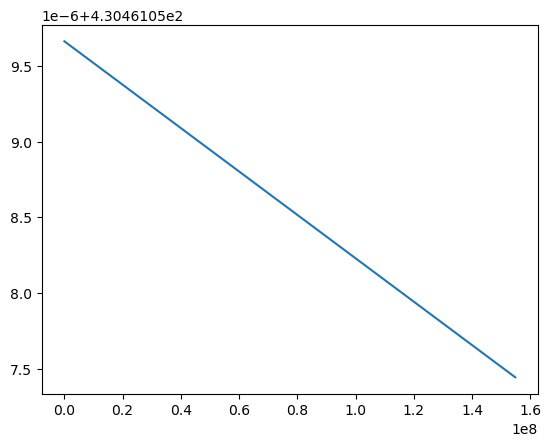

In [44]:
import matplotlib.pyplot as plt

plt.plot(t,f)

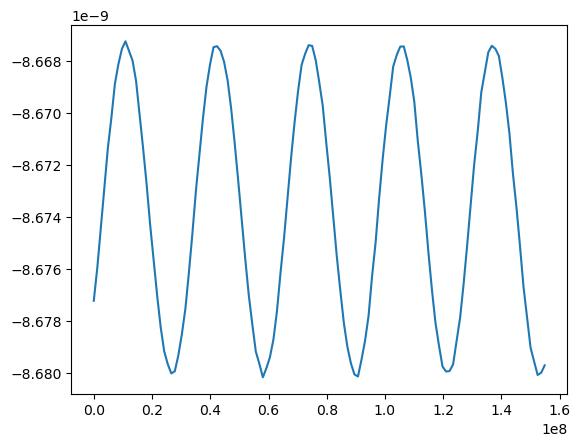

In [41]:
plt.plot(t,fbar)